In [1]:
import tensorflow as tf 
from tensorflow import keras
import os 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import cv2
from scipy import ndimage

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [4]:
# base_path = 'D:/Dropbox/WORK/SNUH/Atopy Segmentation'
base_path = 'C:/Users/user/Desktop/datasets/Atopy Segmentation'
# path_8 = os.path.join(base_path, 'Intersect_0.8')
paths = ['Intersect_0.75', 'Intersect_0.8', 'Intersect_0.85']
grades = ['Grade0', 'Grade1', 'Grade2', 'Grade3']

path = paths[2]
grade = grades[0]
# N_RES = 256

In [5]:
os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.jpg')

'C:/Users/user/Desktop/datasets/Atopy Segmentation\\Intersect_0.85\\Atopy_Segment_Train\\Grade0/*.jpg'

In [6]:
x_train = {}
y_train = {}

x_test = {}
y_test = {}

x_extra = {}
y_extra = {} 


# for path in paths:  
# for grade in grades:
x_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.jpg'))
y_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.png'))

x_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.jpg'))
y_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.png'))

x_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.jpg'))
y_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.png'))

In [7]:
N_RES = 256  
train_images = [] 
train_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_train_list:
    img = cv2.imread(x)
    # img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img / 255.
    # img = np.float32(img)
    
    y = x[:-4] + '.png'
    # print(y)

    # if lbl is None:
    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    # lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.imread(y, 0)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    # lbl = np.float32(lbl) / 255.
    # lbl = [255 for x in lbl if x > 0]
    lbl[lbl > 0] = 1.
    lbl = np.float32(lbl)
    # lbl = lbl[lbl > 0] = 255
    
    
    
    train_images.append(img) 
    train_labels.append(lbl) 
    # 
train_images = np.reshape(train_images, [-1, N_RES, N_RES, 3])
train_labels = np.reshape(train_labels, [-1, N_RES, N_RES, 1])

train_images.shape, train_labels.shape
    

((92, 256, 256, 3), (92, 256, 256, 1))

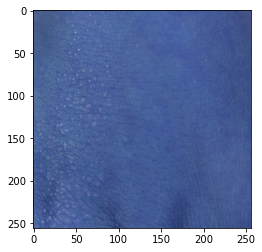

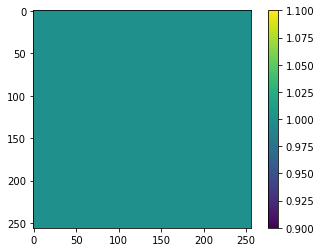

In [8]:
plt.imshow(train_images[0])
plt.show() 

plt.imshow(train_labels[0])
plt.colorbar()
plt.show()

In [9]:
test_images = [] 
test_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_test_list:
    img = cv2.imread(x)
    # img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img / 255.
    # img = np.float32(img)
    
    y = x[:-4] + '.png'
    # print(y)

    # if lbl is None:
    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    # lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.imread(y, 0)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl[lbl > 0] = 1.
    lbl = np.float32(lbl)
    
    
    test_images.append(img) 
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_RES, N_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_RES, N_RES, 1])

In [10]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask = pred_mask[..., tf.newaxis]
    # return pred_mask[0]
    return np.squeeze(pred_mask, axis=0)

from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [11]:
BACKBONE = 'efficientnetb4'
# BACKBONE = 'inceptionv3'
# BACKBONE = 'mobilenetv2'

preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
# train_images = preprocess_input(train_images)
# test_images = preprocess_input(test_images)


In [12]:

model1 = sm.Unet(BACKBONE, encoder_weights='imagenet', activation='sigmoid', input_shape=(N_RES, N_RES, 3))

LR = 0.001
# n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
n_classes = 1


# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', mode='auto', factor=0.2, patience=5, min_lr=0.0001)


model1.compile(
    'Adam',
    # optim, 
    # loss=total_loss,
    # loss='mse', 
    loss=sm.losses.bce_jaccard_loss,
    metrics=metrics,
)


In [13]:

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hist = model1.fit(train_images, 
                 train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                callbacks=[reduce_lr]
                )

Epoch 1/100
10/10 [==============================] - 22s 692ms/step - loss: 1.0341 - iou_score: 0.6895 - f1-score: 0.7998 - val_loss: 41.7562 - val_iou_score: 0.5058 - val_f1-score: 0.6685 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 3s 317ms/step - loss: 0.5887 - iou_score: 0.9190 - f1-score: 0.9577 - val_loss: 165.8231 - val_iou_score: 0.4066 - val_f1-score: 0.5740 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 3s 336ms/step - loss: 0.4171 - iou_score: 0.9372 - f1-score: 0.9675 - val_loss: 56.3093 - val_iou_score: 0.2168 - val_f1-score: 0.3540 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 3s 322ms/step - loss: 0.3212 - iou_score: 0.9485 - f1-score: 0.9735 - val_loss: 9.0562 - val_iou_score: 0.7123 - val_f1-score: 0.8299 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 3s 320ms/step - loss: 0.2783 - iou_score: 0.9455 - f1-score: 0.9719 - val_loss: 18.8603 - val_iou_score: 0.3839 - val_f1-score: 0.5505 - lr: 0

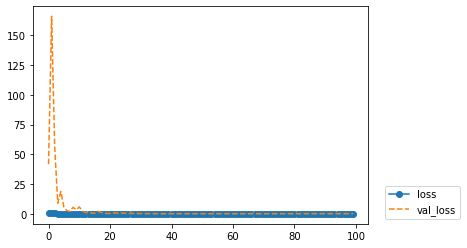

In [14]:
plt.plot(hist.history['loss'], marker='o', label='loss')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend(loc=(1.05, 0.02))
plt.show()

In [18]:
plt.plot(hist.history['iou_score'], label='iou_score')
plt.plot(hist.history['val_iou_score'], '--', label='val_iou_score')
plt.legend(loc=(1.05, 0.02))
plt.show()
    

KeyError: 'accuracy'

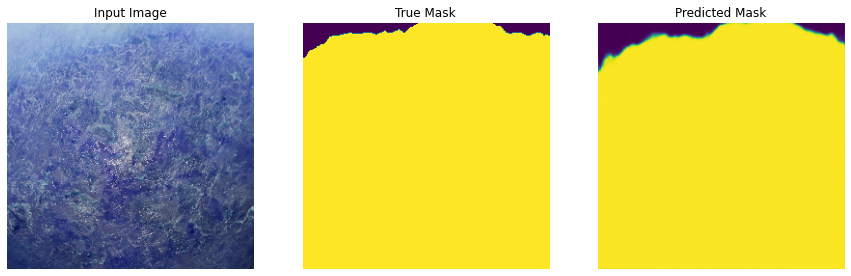

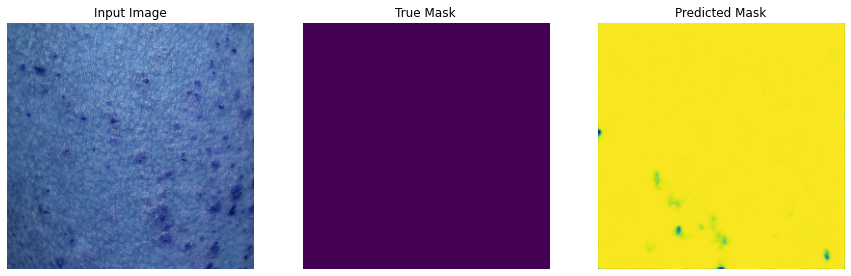

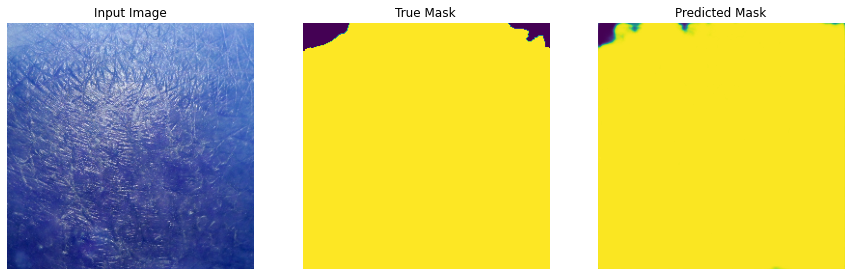

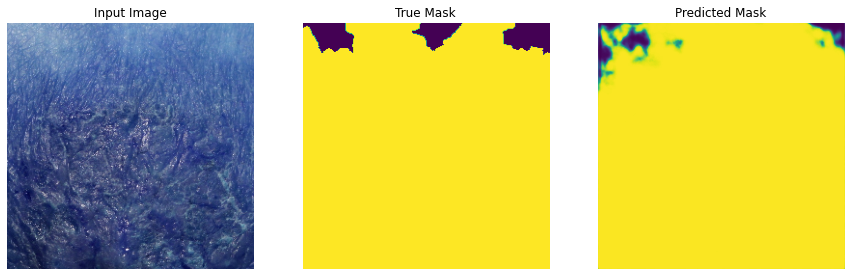

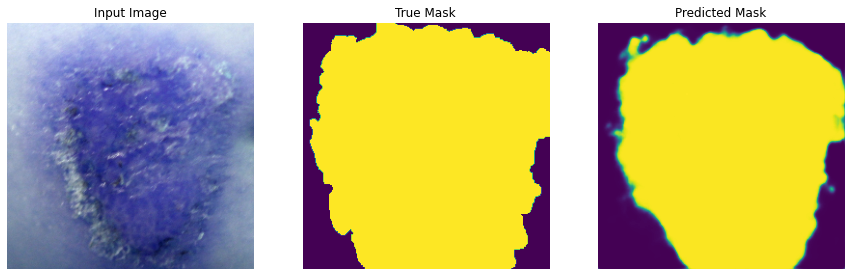

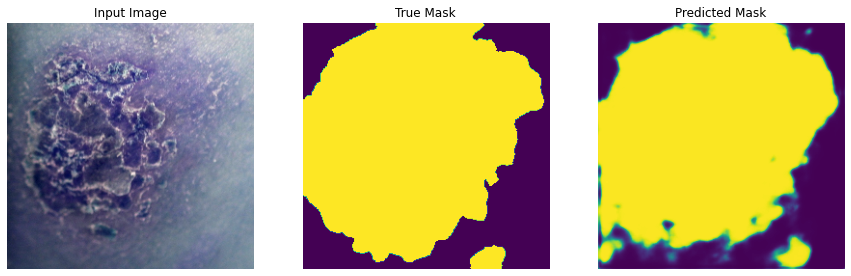

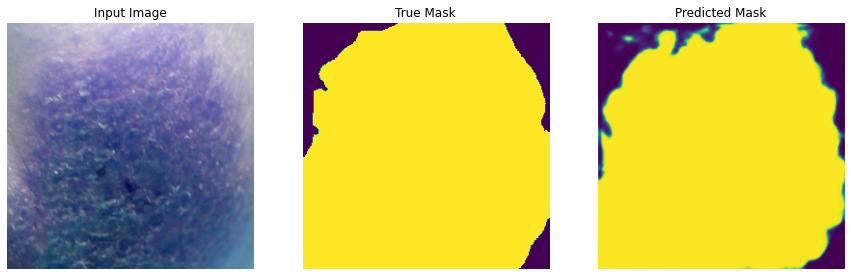

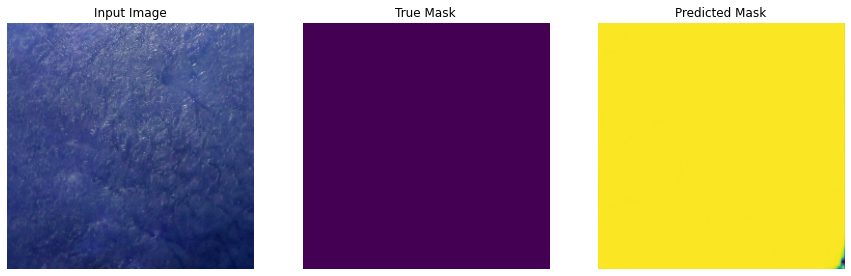

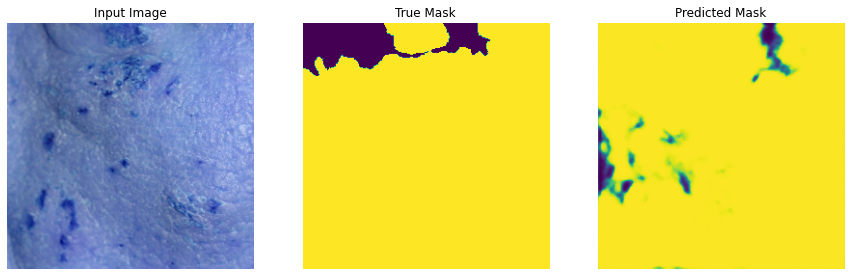

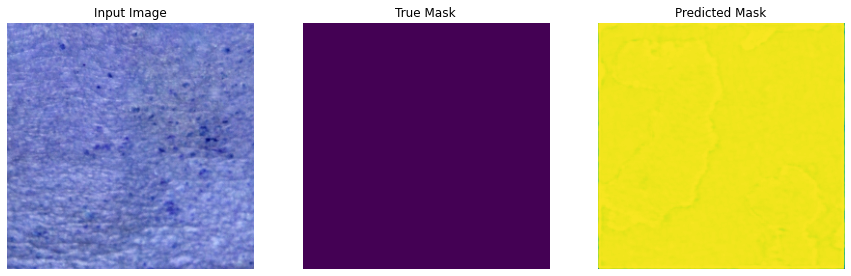

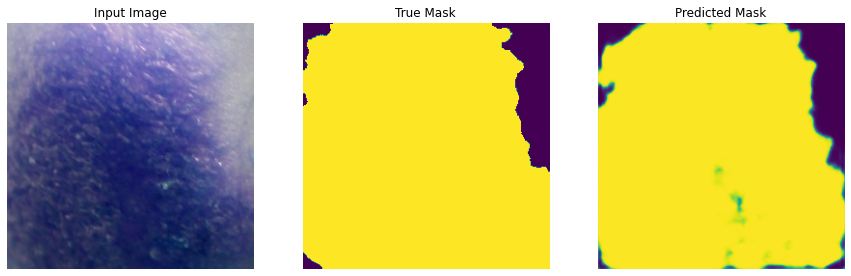

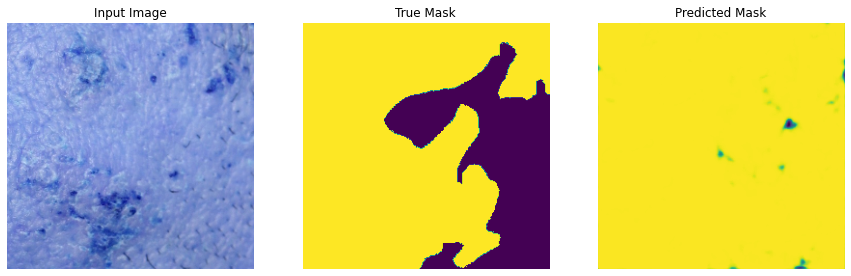

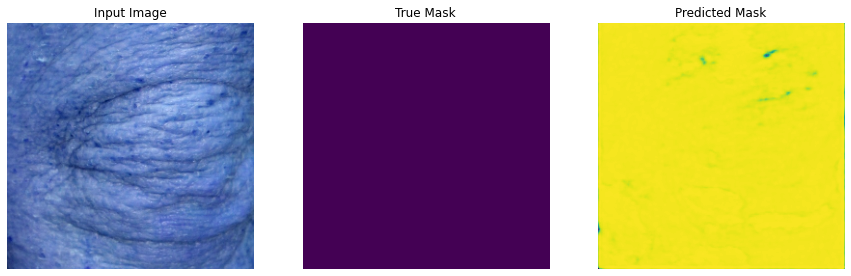

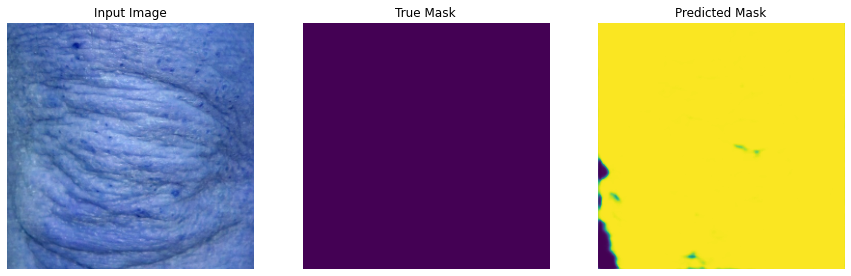

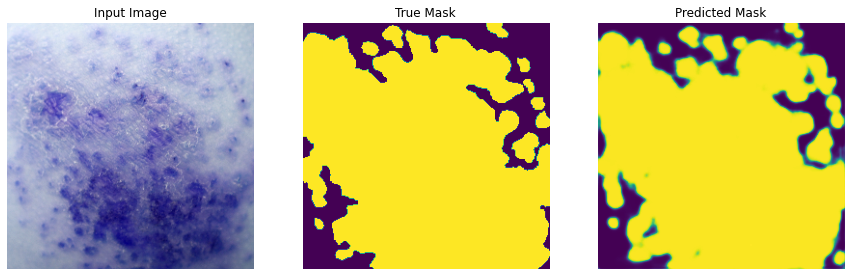

In [19]:
for i in range(0, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model1.predict(sample_img[tf.newaxis, ...]))])
            
    plt.show()

In [30]:
train_images.shape

(221, 256, 256, 3)

In [42]:
aug_size = 100 

randidx = np.random.randint(train_images.shape[0], size=aug_size)
# randidx

x_aug = train_images[randidx].copy() 
y_aug = train_labels[randidx].copy() 


In [13]:
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip


aug_train_images = [] 
aug_train_labels = [] 

for x, y in zip(train_images, train_labels):
    
    aug_train_images.append(x)
    aug_train_labels.append(y) 
    
    aug = RandomRotate90(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = GridDistortion(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = HorizontalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = VerticalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])
    
    
aug_train_images = np.reshape(aug_train_images, [-1, N_RES, N_RES, 3]) 
aug_train_labels = np.reshape(aug_train_labels, [-1, N_RES, N_RES, 1]) 

aug_train_images.shape, aug_train_labels.shape

((460, 256, 256, 3), (460, 256, 256, 1))

In [14]:
# random mix up! 
randidx = np.random.randint(aug_train_images.shape[0], size=aug_train_images.shape[0])
# len(randidx)

mix_train_images = [] 
mix_train_labels = []
for idx in randidx:
    # print(idx)
    mix_train_images.append(aug_train_images[idx])
    mix_train_labels.append(aug_train_labels[idx])
    
    
mix_train_images = np.reshape(mix_train_images, [-1, N_RES, N_RES, 3]) 
mix_train_labels = np.reshape(mix_train_labels, [-1, N_RES, N_RES, 1]) 
    
    

In [15]:
hist = model1.fit(mix_train_images, 
                 mix_train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                callbacks=[reduce_lr]
                )

Epoch 1/100
21/21 [==============================] - 35s 546ms/step - loss: 0.7696 - iou_score: 0.8271 - f1-score: 0.9005 - val_loss: 2.0547 - val_iou_score: 0.7493 - val_f1-score: 0.8561 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 7s 328ms/step - loss: 0.3546 - iou_score: 0.9460 - f1-score: 0.9722 - val_loss: 1.4697 - val_iou_score: 0.8588 - val_f1-score: 0.9236 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 7s 317ms/step - loss: 0.2276 - iou_score: 0.9574 - f1-score: 0.9782 - val_loss: 0.8384 - val_iou_score: 0.9105 - val_f1-score: 0.9530 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 7s 320ms/step - loss: 0.1898 - iou_score: 0.9586 - f1-score: 0.9788 - val_loss: 0.8753 - val_iou_score: 0.8394 - val_f1-score: 0.9126 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 7s 318ms/step - loss: 0.1638 - iou_score: 0.9616 - f1-score: 0.9804 - val_loss: 2.0462 - val_iou_score: 0.5628 - val_f1-score: 0.7191 - lr: 0.0010

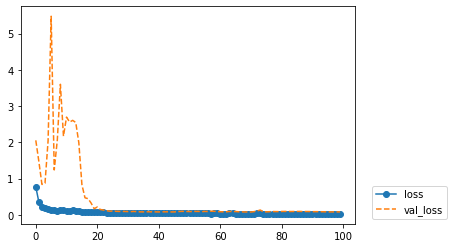

In [16]:
plt.plot(hist.history['loss'], marker='o', label='loss')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend(loc=(1.05, 0.02))
plt.show()

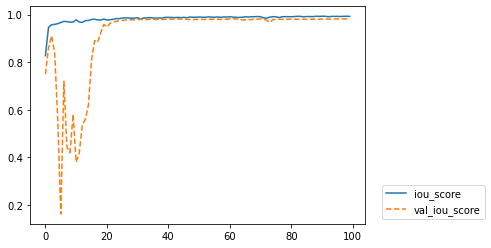

In [17]:
plt.plot(hist.history['iou_score'], label='iou_score')
plt.plot(hist.history['val_iou_score'], '--', label='val_iou_score')
plt.legend(loc=(1.05, 0.02))
plt.show()

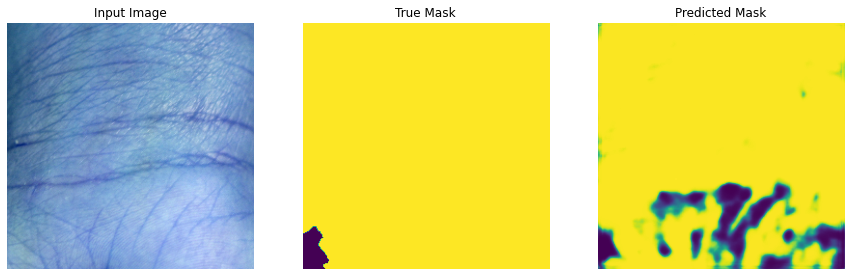

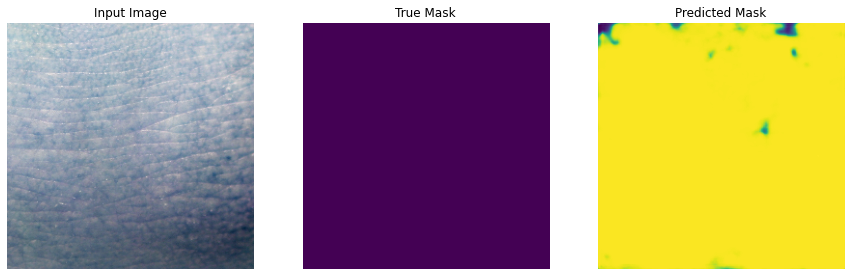

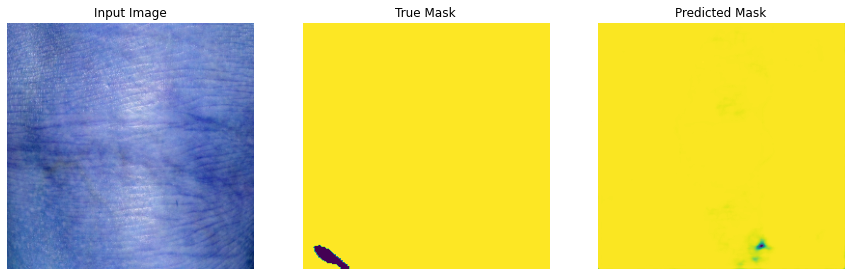

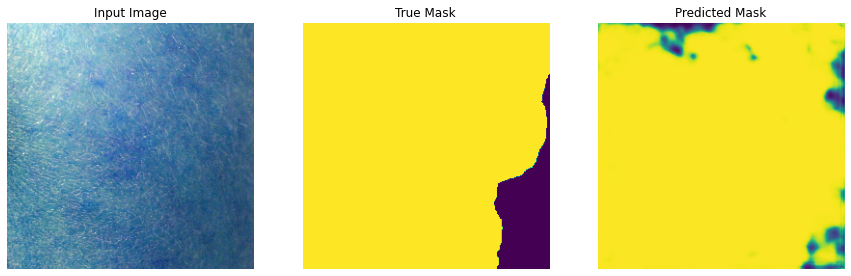

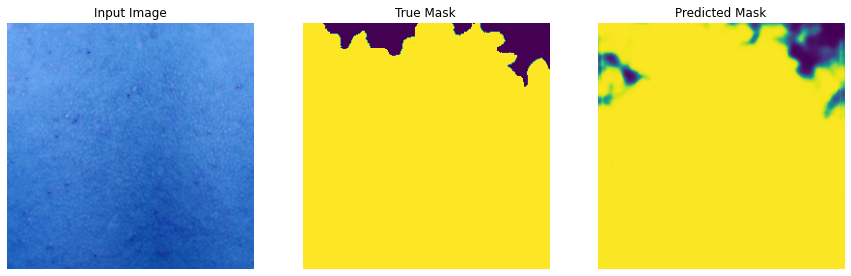

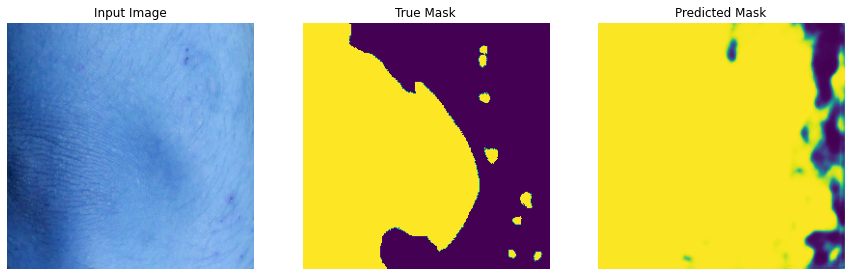

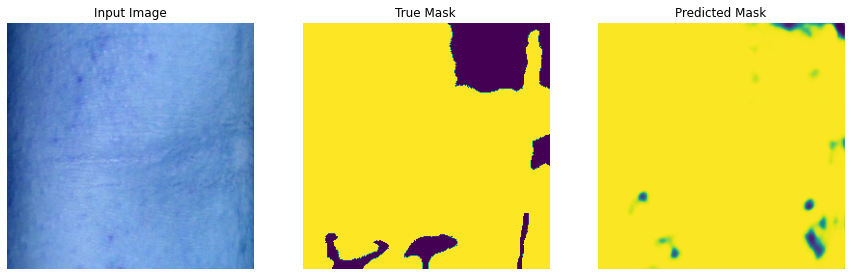

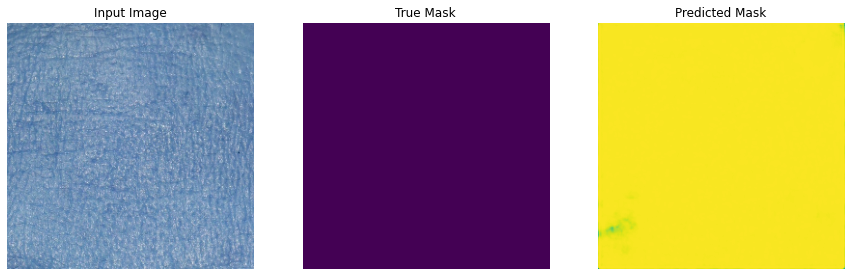

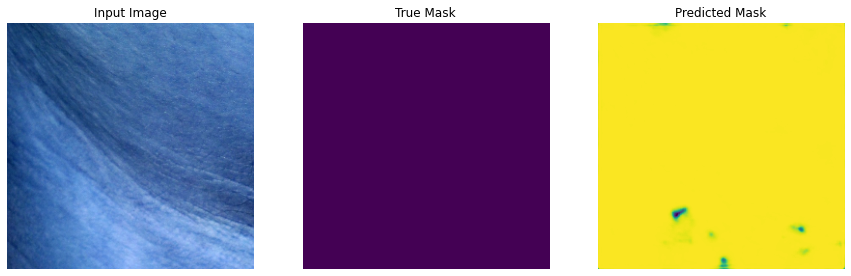

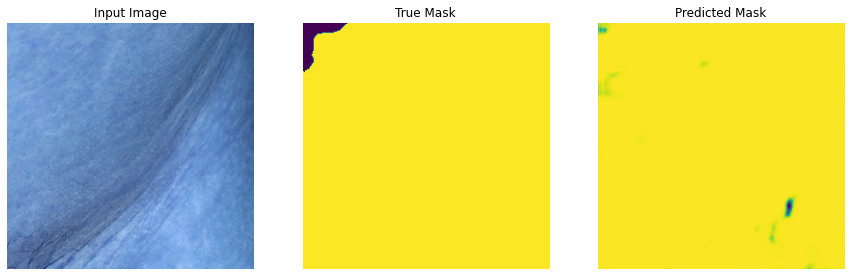

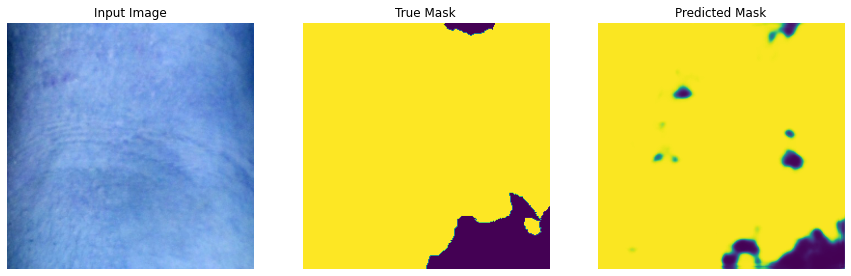

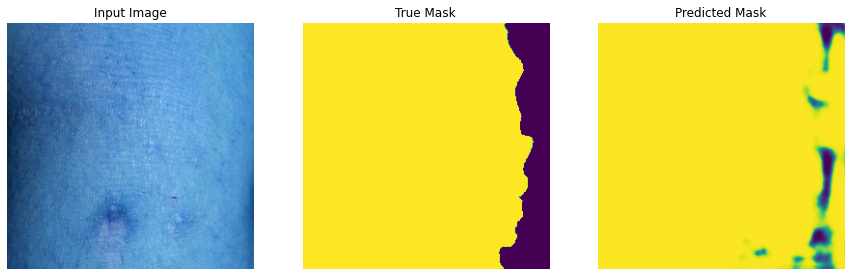

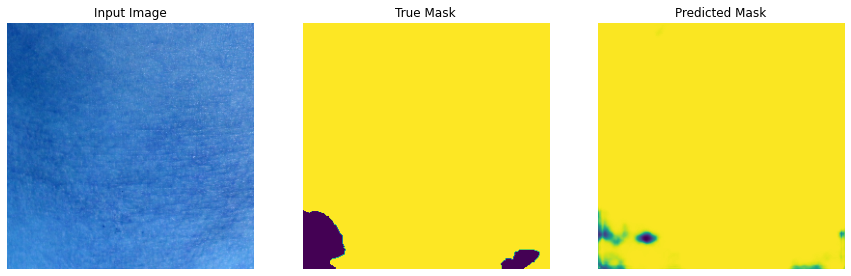

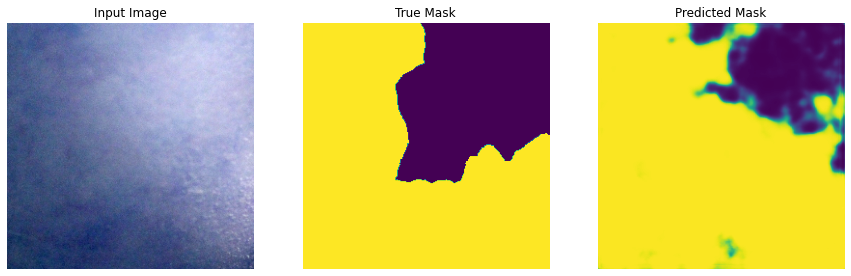

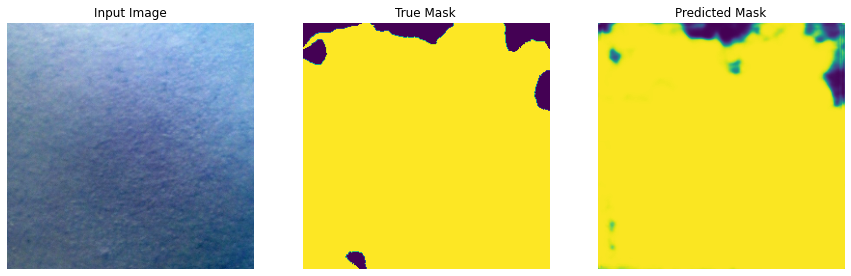

In [18]:
for i in range(0, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model1.predict(sample_img[tf.newaxis, ...]))])
            
    plt.show()

In [ ]:
# ---------------------------------------

In [49]:
N_RES = 256  
train_images = [] 
train_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_train_list:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float32(img)
    
    y = x[:-4] + '.png'
    # print(y)

    # if lbl is None:
    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl = np.float32(lbl)
    
    train_images.append(img) 
    train_labels.append(lbl) 
    # 
train_images = np.reshape(train_images, [-1, N_RES, N_RES, 3])
train_labels = np.reshape(train_labels, [-1, N_RES, N_RES, 1])

test_images = [] 
test_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_test_list:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float32(img)
    
    y = x[:-4] + '.png'

    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl = np.float32(lbl)
        
    # if (lbl == 0).sum() < 1:
    #     # print(f'Not found something : {x}')
    #     none_data += 1 
    #     continue
    
    # lbl = cv2.resize(lbl, (N_RES, N_RES))
    # # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    # # lbl = np.float32(lbl)
    # lbl = lbl.astype('float')
    
    test_images.append(img) 
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_RES, N_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_RES, N_RES, 1])

Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\3367.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\3445.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\5114.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Test\Grade3\7408.jpg
